# Download SWORD database

Altenau et al., (2021) The Surface Water and Ocean Topography (SWOT) Mission River Database (SWORD): A Global River Network for Satellite Data Products. Water Resources Research. https://doi.org/10.1029/2021WR030054

`wget https://zenodo.org/record/7410433/files/SWORD_v14_nc.zip?download=1`

# Read database

In [1]:
from dask.distributed import Client
import xarray as xr
import rioxarray as rxr
from pathlib import Path
import geopandas as gpd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client(n_workers=4, threads_per_worker=2)
client

2023-02-25 11:51:03,969 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-xu1ab77w', purging
2023-02-25 11:51:03,969 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-3n8wzcw4', purging
2023-02-25 11:51:03,969 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-o3xkoxba', purging
2023-02-25 11:51:03,969 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wzsvpjyi', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35095,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:34212,Total threads: 2
Dashboard: http://127.0.0.1:45859/status,Memory: 46.89 GiB
Nanny: tcp://127.0.0.1:36373,


In [3]:
sword_ds_na_fp = Path('../../data/sword_db/na_sword_v14.nc')
print(sword_ds_na_fp.exists())
sword_ds_na = xr.open_dataset(sword_ds_na_fp, chunks={'num_reaches': 1000}, engine='netcdf4', group='reaches')
sword_ds_na

True


<xarray.Dataset>
Dimensions:         (num_reaches: 37644, num_ids: 2, num_domains: 4,
                     julian_day: 366, orbits: 75)
Dimensions without coordinates: num_reaches, num_ids, num_domains, julian_day,
                                orbits
Data variables: (12/34)
    reach_id        (num_reaches) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    cl_ids          (num_ids, num_reaches) float64 dask.array<chunksize=(2, 1000), meta=np.ndarray>
    x               (num_reaches) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    x_min           (num_reaches) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    x_max           (num_reaches) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    y               (num_reaches) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    ...              ...
    swot_obs        (num_reaches) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    swot_orbits     (orbits, num_reaches) float64 dask.array<chunksize=(75, 1000), meta=np.ndarray>
    river_name      (num_reaches) object dask.array<chunksize=(1000,), meta=np.ndarray>
    max_width       (num_reaches) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    low_slope_flag  (num_reaches) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    edit_flag       (num_reaches) object dask.array<chunksize=(1000,), meta=np.ndarray>

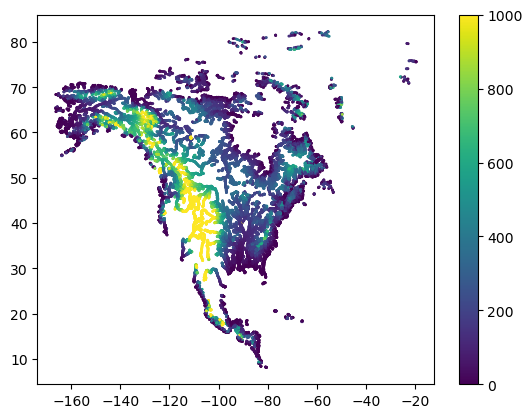

In [4]:
from matplotlib import pyplot as plt

plt.scatter(sword_ds_na.x, sword_ds_na.y, s=1, c=sword_ds_na.wse, vmax=1000)
plt.colorbar()

In [5]:
# read in gunnison boundary and limit the dataset accordingly
gunnison_boundary_fp = Path("../../data/basin_shapefile/gunnison_boundary/gunnison_boundary.shp")
gunnison_boundary = gpd.read_file(gunnison_boundary_fp)

In [6]:
# clip SWORD db to gunnison
rb = sword_ds_na.x.values <= gunnison_boundary.bounds['maxx'][0]
lb = sword_ds_na.x.values >= gunnison_boundary.bounds['minx'][0]
tb = sword_ds_na.y.values <= gunnison_boundary.bounds['maxy'][0]
bb = sword_ds_na.y.values >= gunnison_boundary.bounds['miny'][0]

sword_gunnison = sword_ds_na.sel(num_reaches=(rb&lb&tb&bb))

<GeoAxesSubplot:>

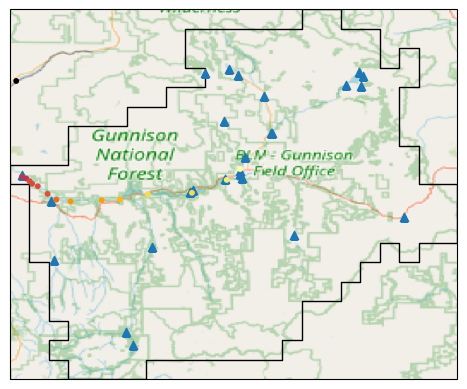

In [7]:
stations_fn = Path("../../data/usgs_gage_locations/usgs_gages.csv")
stations = pd.read_csv(stations_fn, dtype={'site_no': str})
stations['geometry'] = gpd.GeoSeries.from_wkt(stations['geometry'])
stations = gpd.GeoDataFrame(stations)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import warnings
warnings.filterwarnings('ignore')

fn = Path('../../data/basin_shapefile/gunnison_boundary/gunnison_boundary.shp')

def plot_map(fn, plot_stations=True, plot_boundary=True):
    gunnison_boundary = gpd.read_file(fn)
    gunnison_boundary.bounds.values[0]

    f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

    extent = gunnison_boundary.bounds[['minx', 'maxx', 'miny', 'maxy']].values[0]
    request = cimgt.OSM()
    ax.set_extent(extent)
    ax.add_image(request, 8)
    if plot_boundary:
        gunnison_boundary.plot(ax=ax, fc='none')
    if plot_stations:
        stations.plot(ax=ax, marker='^')

    return f, ax

f, ax = plot_map(fn)

ax.scatter(sword_gunnison.x, sword_gunnison.y, c=sword_gunnison.wse, linewidth=1, s=10, fc='black', cmap='inferno')

ax

In [8]:
[f"{rch_id:}" for rch_id in sword_gunnison['rch_id_dn'].values[0]]

['77280400191.0',
 '77280400204.0',
 '77280400221.0',
 '77280400234.0',
 '77280400243.0',
 '77280400251.0',
 '77280400261.0',
 '77280400274.0',
 '77280400283.0',
 '77280400291.0',
 '77280400304.0',
 '77280400313.0',
 '77280400323.0',
 '77280400331.0',
 '77280400351.0']